# Exercises

## Exercise 1: Image characteristics
---

**A.** Distiguishing pixels   

Fluctuations in the activitation of the neuron can be directly observed on the video or in a temporal trace plot of each pixel. Plotting the temporal trace will allow us to see the calcium transient dinamic, if a pixel belonging to a neuron is selected. 

* Select a set of *N* random pixels from the ROI and plot the temporal evolution of pixel value. If the random pixels are choosen from an active neuron, you will be able to see the calcium transcient dynamic. Try this a few time to appreciate the results.

**B.** Temporal statistics of pixel activation
 * For the selected pixels, plot the histogram of pixel value. What are the difference in different regions?, and how can that help to distinguish a pixel that belongs to aneuron from a background pixel?

* If we can already see the calcium traces from individual pixels, why do we need to run source extraction to segment the neurons? Why, as a starter, would not be a good idea to work directly with the temporal traces of the pixels? 

In [4]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import psutil
from pathlib import Path
import os

# CaImAn funtions and objects
import caiman as cm
from caiman.motion_correction import MotionCorrect, high_pass_filter_space
from caiman.source_extraction.cnmf import params as params
from caiman.source_extraction import cnmf
from caiman.source_extraction.cnmf.cnmf import load_CNMF

import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import auxiliary_functions as aux
import normalization_functions as nf


import seaborn as sns
sns.set_theme(context='notebook',style='white',font_scale=1.5)

In [5]:
# download data for the lesson (this can take a few minutes)
download_data('https://surfdrive.surf.nl/files/index.php/s/HeYXPdvMO87fbq7')

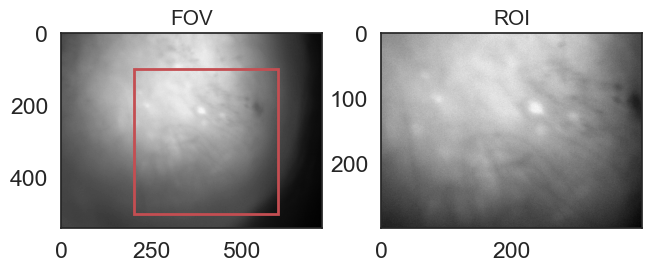

In [6]:

# Set path to video of the full field of view
input_tif_file_path_FOV = 'data/calcium_video.tif'
input_tif_file_path = 'data/caiman_video_trial_0.tif'
FOV = cm.load(input_tif_file_path_FOV)  # Load video with complete field of view (FOV)

# Play video (a new window will open)
FOV.play(gain=1,  # Light intensity of video
         magnification=1,  # Size of display movie
         fr=20)  # Frame rate at which the movie is played

# Visualize the FOV and the ROI
aux.plot_FOV(FOV_file=input_tif_file_path_FOV, ROI_file=input_tif_file_path)


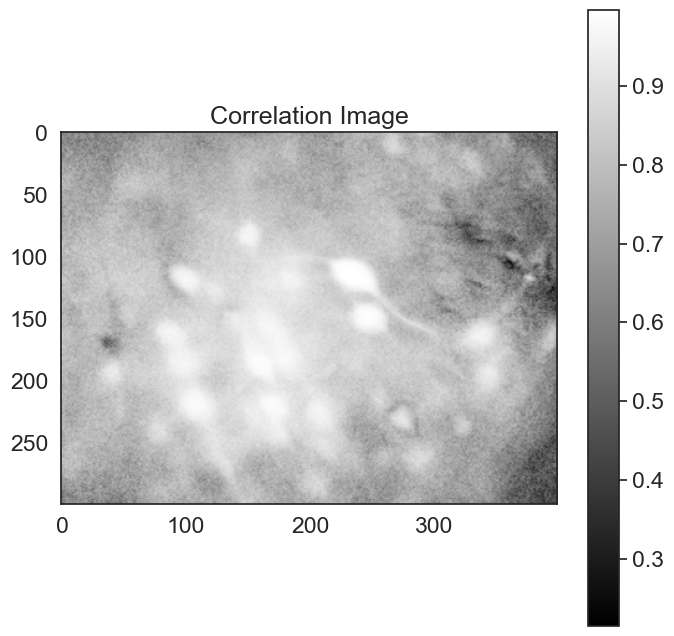

In [12]:
# Load movie and ROI
original_movie = cm.load(input_tif_file_path)
# Compute correlation image to use as ROI
correlation_image, pnr_image = cm.summary_images.correlation_pnr(original_movie, swap_dim=False)

# Plot the correlation image
plt.figure(figsize=(8, 8))
plt.imshow(correlation_image, cmap='gray')
plt.title('Correlation Image')
plt.colorbar()
plt.show()

In [13]:
# Define the number of random pixels to select
N = 10  

# Assume the ROI is the non-zero regions of the correlation image
roi_coords = np.column_stack(np.where(correlation_image > 0))

# Select N random pixels from the ROI
random_pixels = roi_coords[np.random.choice(roi_coords.shape[0], N, replace=False)]


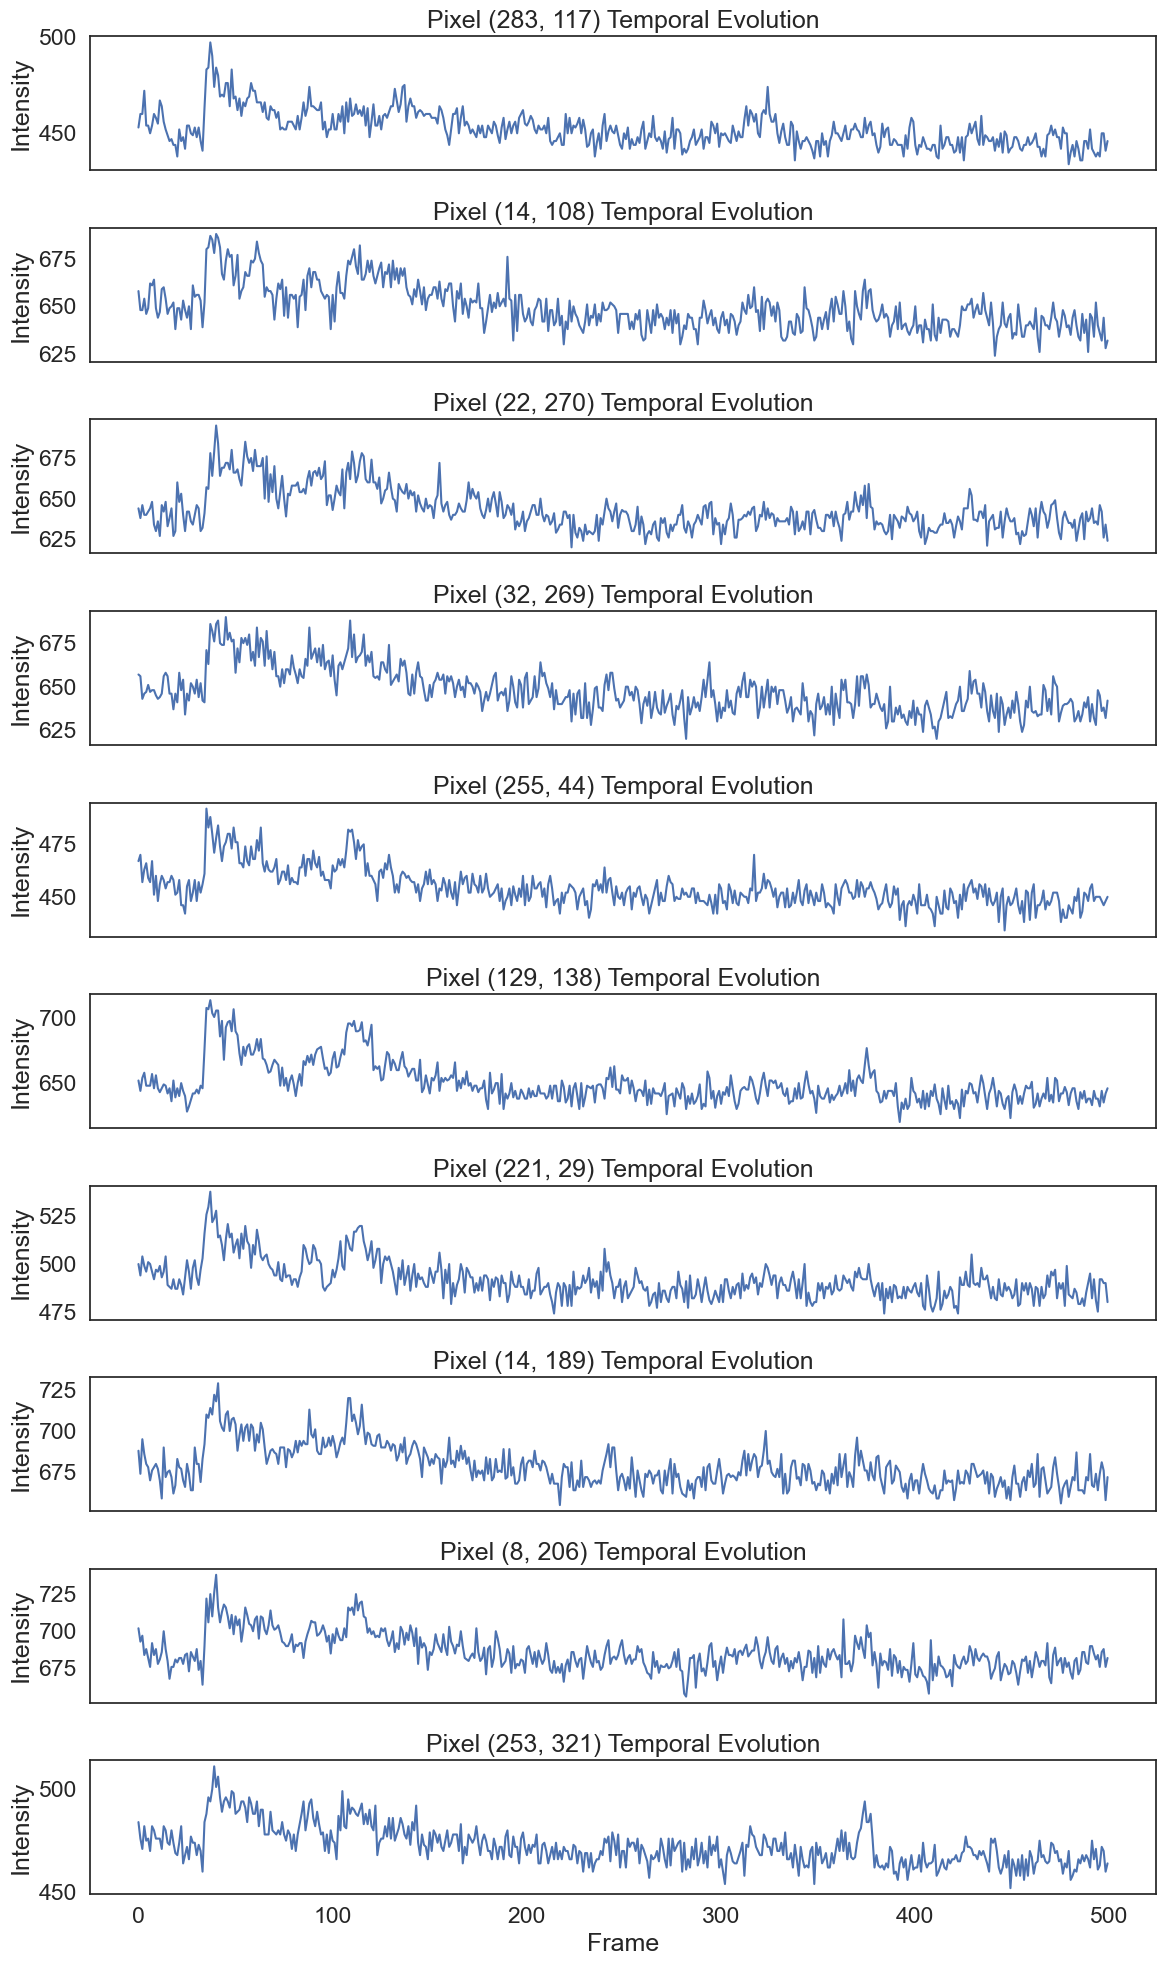

In [17]:
# Plot temporal evolution of pixel values
fig, axes = plt.subplots(N, 1, figsize=(12, 2 * N), sharex=True)

for i, (y, x) in enumerate(random_pixels):
    pixel_trace = original_movie[:, y, x]
    axes[i].plot(pixel_trace)
    axes[i].set_title(f'Pixel ({y}, {x}) Temporal Evolution')
    axes[i].set_ylabel('Intensity')

axes[-1].set_xlabel('Frame')
plt.tight_layout()
plt.show()


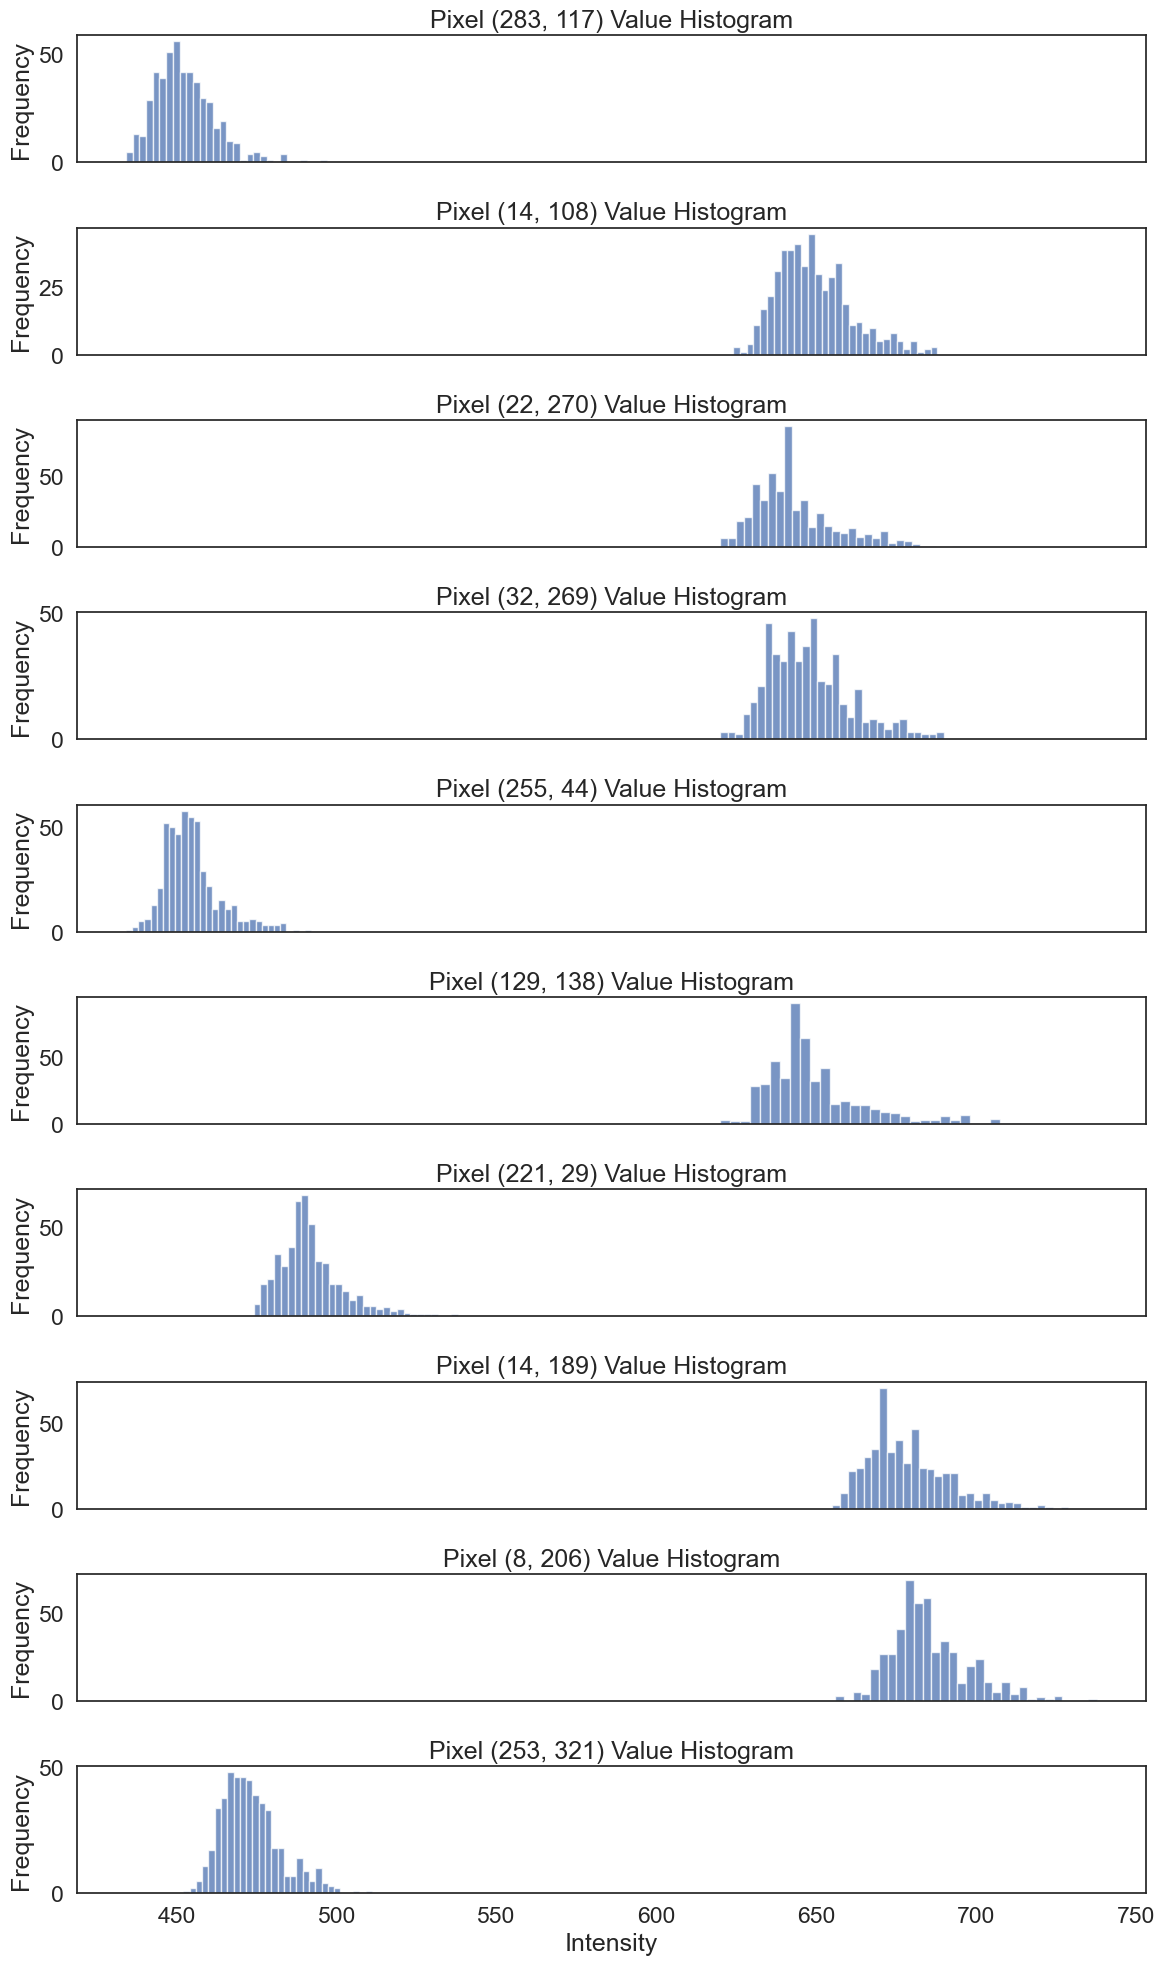

In [18]:
# Plot histogram of pixel values
fig, axes = plt.subplots(N, 1, figsize=(12, 2 * N), sharex=True)

for i, (y, x) in enumerate(random_pixels):
    pixel_trace = original_movie[:, y, x]
    axes[i].hist(pixel_trace, bins=30, alpha=0.75)
    axes[i].set_title(f'Pixel ({y}, {x}) Value Histogram')
    axes[i].set_ylabel('Frequency')

axes[-1].set_xlabel('Intensity')
plt.tight_layout()
plt.show()


**What are the difference in different regions?**
- Pixels such as (14, 108), (32, 269), (14, 189), (8, 206) exhibit broader histograms with a higher range of intensity values. These histograms often have multiple peaks or a broad distribution, indicating variability in the pixel intensity due to calcium transients.
- Pixels such as (283, 117), (255, 44), (221, 29), and (253, 321) have narrower histograms centered around a lower intensity value. These histograms show a single peak with lower intensity values and less variability, indicating stable background activity without significant transients.

**and how can that help to distinguish a pixel that belongs to aneuron from a background pixel?**

- the broader histograms with higher variability and multiple peaks suggest the presence of dynamic calcium transients. This indicates that these pixels likely belong to active neurons.
While narrower histograms with a single peak and lower intensity values suggest stable, consistent background activity. These pixels are less likely to be part of active neurons and more likely be part of background.


**If we can already see the calcium traces from individual pixels, why do we need to run source extraction to segment the neurons?**
- Neurons are not single pixels but extended structures. Their activity influences multiple adjacent pixels. Source extraction aggregates this activity to segment the entire neuron accurately.
- Individual pixel traces can be noisy, making it difficult to distinguish real calcium events from noise. Source extraction combines signals over multiple pixels, enhancing the signal-to-noise ratio and making it easier to identify true neuronal activity.
- Source extraction algorithms use both temporal and spatial information to accurately identify and segment neurons. This dual information approach is not possible with temporal traces alone, leading to more robust and reliable neuron identification.
- Analyzing temporal traces of individual pixels can result in fragmented and noisy data, making it challenging to draw meaningful conclusions. Source extraction provides a more cohesive and accurate representation of neuronal activity.
**Why, as a starter, would not be a good idea to work directly with the temporal traces of the pixels?**
 - Neurons have complex shapes and sizes. Relying solely on temporal traces from individual pixels can miss the full extent of neuronal structures, leading to incomplete analysis.
 - Neuronal activity often overlaps in both time and space. Source extraction can disentangle these overlaps, which is not feasible with pixel-level temporal traces alone.
 - Source extraction methods are designed to detect subtle and overlapping signals from neurons, which may not be apparent in individual pixel traces. This leads to better detection and segmentation of neuronal activity.

## Exercise 2: motion correction parameters
---

One parameter that impacts motion correction performance is the size of the spatial filter that is applyed to the video.

* Use the following function from CaImAn and plot the result of different space filtering applyed to a single frame of the video:from caiman.motion_correction import high_pass_filter_space

* How will this filtering affect the measure of crispness?

* Acording to Pnevmatikakis et al, which other factors are relevant for pw-rigid motion correction?

- Explore the impact of different parameters in the output of motion correction algorithm by measuring crispness in the correlation image of the final outcome. Particularly measure the effect of different spatial filter size by applying motion correction algorithm multiple times and computing the crispness of the output video. 

- Display all crispness values for rigid and not rigid motion correction and plot them agains gSig_filters values.

- If possible, show the impact of the crispness value that comes from changing other relevant paraments.

*Note1: The is no need to save all the motion corrected movies, just save the cripsness values.*

*Note2: gSig_filters is an optional range of posible values, but if your computer gets to slow in the computation reduce the range.*


## Exercise 3: Source extraction parameters 
---

* For a fixed minimum correlation value (ie 0.6) select a range of possible PNR minimun values and study the impact of those in the final source extraction output.

* For a fixed value of PNR (ie 6) select a range of minimum correlation valur and study the impact of those in the final source extraction output.

* How do these paramenters affect the spatial sparcity of the output? Which set of parameter selection procedes the higher number of neurons? Is maximal number of neurons always better? Why?  

* Generate a plot of number of neurons vs PNR (or min corr value) to show how these parameters affect the source extracted signals.

* Are the temporal traces affected by these parameters?

* For different PNR and minimum correlation value plot the correlation image and the selected cells.